# Imports

We start by a section who will contain general purpose libraries. 

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [10]:
import bz2
import json
import time
import pandas as pd
import numpy as np
from pprint import pprint

In [11]:
LINE_CHECKPOINT = 1e6
ROOT = '/content/drive/MyDrive/ada_project/'
DATA_FOLDER_PATH = ROOT + 'data/'
ORIGINAL_DATASETS_FOLDER_PATH = DATA_FOLDER_PATH + 'Quotebank/'
SHRANK_DATASETS_FOLDER_PATH = DATA_FOLDER_PATH + 'quotebank_cleaned/'
NEWS_SOURCES_FILE_PATH = DATA_FOLDER_PATH + 'news_sources/news_sources.csv'
PARQUET_FILE_PATH = DATA_FOLDER_PATH + 'speaker_attributes.parquet'

# Quotebank Data

## Example of Data
Pretty printing a single entry as reference.

In [12]:
with bz2.open(ORIGINAL_DATASETS_FOLDER_PATH + 'quotes-2020.json.bz2', 'rb') as t_file:
    pprint(json.loads(t_file.readline()))

{'date': '2020-01-28 08:04:05',
 'numOccurrences': 1,
 'phase': 'E',
 'probas': [['None', '0.7272'],
            ['Prime Minister Netanyahu', '0.2445'],
            ['Natan Sharansky', '0.0283']],
 'qids': [],
 'quotation': '[ D ] espite the efforts of the partners to create a '
              'non-political award that unites the Jewish people, some have '
              'incorrectly interpreted the participation of the Office of the '
              'Prime Minister in the Genesis Prize as bringing a political '
              'dimension to this important initiative,',
 'quoteID': '2020-01-28-000082',
 'speaker': 'None',
 'urls': ['http://israelnationalnews.com/News/News.aspx/275210']}


## Making Data Manageable
The provided datasets contain a lot of information that is not relevant to our goal, therefore we have decided to perform a first round of pruning.
We removed all quotations that were not assigned to any speaker, and stripped the remaining ones of `date` and `numOccurrences` fields.
The latter one does not help us, as we cannot distinguish occurrences in different news sources. This is not a significant problem, as we will see later on.

With the shrinked versions of the yearly datasets we are able to perform all following operations more swiftly.

In [ ]:
def shrink_archive(source_path, destination_path):
    """Shrink the bz2 archive supplied as source_path by removing data unnecessary for the project.
    Unnecessary data includes:
        - all entries where the speaker has not been identified
        - date fields. The date part can be retrieved from the ID if needed.
        - numOccurrences field"""
    print("Shrinking {} to {}".format(source_path, destination_path))
    with bz2.open(source_path, 'rb') as s_file:
        with bz2.open(destination_path, 'wb') as d_file:
            time_start = time.time()
            for i, s_line in enumerate(s_file):
                quote_dict = json.loads(s_line) # Load current line into py dict
                if quote_dict['speaker'] != 'None':
                    # If a speaker is present, shrink and save the dictionary
                    # Remove date, can be retrieved from id if needed
                    del quote_dict['date']
                    del quote_dict['numOccurrences'] # Remove numOccurrances, not needed
                    # writing in the new file
                    d_file.write((json.dumps(quote_dict)+'\n').encode('utf-8'))
                if i % LINE_CHECKPOINT == 0: print("On line {}...".format(i)) # Visual feedback
    print("--- %s seconds ---" % (time.time() - time_start))
    print("Done, processed {} lines.".format(i))

In [ ]:
for i in range(2015, 2020):
    path_to_file_i = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'.format(i)
    path_to_file_shrank = '/content/drive/MyDrive/quotebank_cleaned/quotes-{}-shrank.json.bz2'.format(i)
    shrink_archive(path_to_file_i, path_to_file_shrank)

## Benchmarking
The following snippet show how much time we are able to save when operating with reduced versions of the datasets.

In [32]:
def stopwatch_dataset(source_path):
    """Utility function created to roughly estimate time needed to cycle through a provided dataset"""
    print("Stop-watching ", source_path)
    with bz2.open(source_path, 'rb') as s_file:
        time_start = time.time()
        for i, s_line in enumerate(s_file):
            if i % LINE_CHECKPOINT == 0: print("On line {}...".format(i)) # Visual feedback
    print("--- %s seconds ---" % (time.time() - time_start))

In [ ]:
test_year = 2020
stopwatch_dataset('{}quotes-{}.json.bz2'.format(ORIGINAL_DATASETS_FOLDER_PATH, test_year))
stopwatch_dataset('{}quotes-{}-shrank.json.bz2'.format(SHRANK_DATASETS_FOLDER_PATH, test_year))

## Utility Method

We've created an utility method to access the shrank version of datasets.

In [35]:
def load_shrank_dataset(year):
    year = int(year)
    if year < 2015 or year > 2020: raise ValueError("Provide a year between 2015 and 2020.")
    # Remember to close the file stream!
    return bz2.open('{}quotes-{}-shrank.json.bz2'.format(SHRANK_DATASETS_FOLDER_PATH, year), 'rb')

# Wikidata

In [14]:
wiki_df = pd.read_parquet(PARQUET_FILE_PATH)

In [15]:
wiki_df.shape[0]

9055981

## Data Inspection
Here is a quick exemple on how to search/filter for a specific politician, knowing boxes contain lists, not only strings.

In [16]:
# Searching for a specific politician. Just replace the name here. Note : it is case sensitive by default. 
# Use either what is present in the aliases field or the label field. 

mask = wiki_df["label"].str.contains("Bush", regex = False, na = False)

# Change number of desired results here 
wiki_df[mask][:10]

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
11351,[Vanevar Bush],[+1890-03-11T00:00:00Z],[Q30],[Q6581097],1392187290,None,None,"[Q82594, Q205375, Q82955, Q1622272, Q81096]",None,None,Q299595,Vannevar Bush,None,item,[Q55004488]
12327,[Prescott Sheldon Bush],[+1895-05-15T00:00:00Z],[Q30],[Q6581097],1393428512,[Q7435494],B001167,"[Q82955, Q806798, Q4416090]",[Q29468],None,Q324742,Prescott Bush,None,item,[Q682443]
16876,None,[+1955-12-24T00:00:00Z],[Q30],[Q6581097],1388311017,[Q49085],None,"[Q10800557, Q10798782]",None,None,Q452552,Grand L. Bush,None,item,None
17154,None,[+1984-06-25T00:00:00Z],[Q30],[Q6581072],1392040371,None,None,"[Q4610556, Q33999, Q3501317]",None,None,Q456169,Lauren Bush,None,item,None
20670,None,[+1970-09-20T00:00:00Z],[Q30],[Q6581072],1391193823,[Q49085],None,"[Q33999, Q10800557, Q10798782]",None,None,Q536025,N'Bushe Wright,None,item,None
44750,"[Marvin Bush, Marvin Pierce Bush]",[+1956-10-22T00:00:00Z],[Q30],[Q6581097],1311310452,None,None,[Q43845],None,None,Q1375345,Marvin P. Bush,None,item,None
44772,[Samuel Prescott Bush],[+1863-10-04T00:00:00Z],[Q30],[Q6581097],1373387625,None,None,"[Q43845, Q131524]",None,None,Q1376227,Samuel P. Bush,None,item,None
45548,None,[+1869-01-20T00:00:00Z],[Q30],[Q6581097],1323621663,None,None,"[Q1622272, Q2504617]",None,None,Q1394511,Albert Bushnell Johnson,None,item,None
52576,None,[+1921-12-16T00:00:00Z],[Q183],[Q6581097],1329921163,None,None,"[Q9385011, Q1622272]",None,None,Q1592275,Karl-August Bushe,None,item,None


## Summary : available fields and infos 
- Each person is identified by an id (column id), matching the one on wikipedia
- Label contains one specific label for this person, as it appears in wikipedia's url. 
- Aliases contain the most used names to refer to this person. Can be empty if no other than the one indicated in labels. 
- Infos are either none, or the reference of a QID article. Mostly, these references are created when a link to a referenced wikipedia elements is added in a person's wikipedia page. 
- Occupation QIDs can be relevant for us. Sample QIDs are: Q82955 - Politician, Q189290 - Military officier, Q39631 - Physician (medicine), Q30461 - President... 
- Political party is also given, if any. For congresspersons, their corresponding ID is also given. 
- No time distinction is available, i.e. if a person changed its political party (or any other attribute available here) during his life, both political parties will be indicated. 

## Issues : missing data
- Some data are clearly missing above. George W. Bush may not be the smartest person alive, but he still holds a couple of academic degrees. For some people the degree is simply indicated as text (and not a hyperlink) in the wikipedia page, but it's not the case for all. George's biography clearly states a Bachelor of Arts as a hyperlink although we can not find it in the data set. It may be a timing issue.  
- In consequence, let's inspect how the fields of interest for us will be impacted by missing data. 

First, we will start by removing people born before 1900 from our dataset. There are 3 main reasons : 
- They do not truly impact how biased a news source is in reporting current events, even though we could expect conservative newspapers to cite more secessionist generals and left-wing newspapers to cite more Martin Luther King. 
- American political parties used to switch from left to right (fun fact : Lincoln was a Republican, left-wing at that time) and there were a few major older parties that disapeared today. 
- Completeness of the dataset for people born long time ago is expected to be low : there were no "political parties" at the time of Cesar. 

In [17]:
# convert the array of strings to a integer year. We keep only the year, for those born after 1900 
def filter_date_1900(x):
    if x is not None:
        # we don't care about those born in before J.C (- as first character) or before 1900
        if (x[0])[0] == "+" and int((x[0])[1:5]) >= 1900 :
            return int((x[0])[1:5])
        else: 
            return None

wiki_df["date_of_birth"] = wiki_df["date_of_birth"].apply(lambda x: filter_date_1900(x))
# we discard the na value. Note that this could also discard a few people that simply 
# did not had their date of birth in wikidata, but may be born afterwards. 

wiki_df = wiki_df.dropna(subset = ["date_of_birth"])
wiki_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",1952.0,[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",1946.0,[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
5,"[Augusto Pinochet Ugarte, Augusto José Ramón P...",1915.0,[Q298],[Q6581097],1392242213,None,None,"[Q189290, Q82955]",[Q327591],None,Q368,Augusto Pinochet,None,item,[Q1841]
8,"[Neil Percival Young, Shakey, Godfather of Gru...",1945.0,"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
9,None,1969.0,[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [18]:
# Proportion of no academic degree or missing academic degrees. 
no_academic_found = wiki_df[wiki_df["academic_degree"].isnull()].size 
print("The proportion of people with no academic degree found is {0:.1%}".format(no_academic_found/wiki_df.size))

The proportion of people with no academic degree found is 98.1%


In [19]:
# Proportion of missing occupations. 

no_occupation_found = wiki_df[wiki_df["occupation"].isnull()].size 
print("The proportion of people with no occupation found is {0:.1%}".format(no_occupation_found/wiki_df.size))

The proportion of people with no occupation found is 16.6%


There is clearly some issue with the academic degrees, we may not want to use this field. In terms of occupation, "only" 16% are missing. Here is a small example of such cases. 

In [20]:
wiki_df[wiki_df["occupation"].isnull()].head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
72,None,1919.0,None,[Q6581097],1390158852,None,None,None,None,None,Q4291,Ante Bilobrk,None,item,None
545,None,1958.0,None,[Q6581097],1309589591,[Q127885],None,None,None,None,Q29830,Vukašin Šoškoćanin,None,item,None
604,"[Greg DePalma, Gregory J. DePalma]",1932.0,None,[Q6581097],1309589720,None,None,None,None,None,Q33371,Gregory DePalma,None,item,None
1030,None,1924.0,None,[Q6581097],1390159368,None,None,None,None,None,Q53595,Pranas Brazinskas,None,item,None
2289,None,1922.0,[Q15180],[Q6581097],1327065855,None,None,None,[Q79854],None,Q73926,Oleg Goncharenko,None,item,None


Now, let's check for integrity in terms of political parties.

In [21]:
have_political_party = wiki_df[wiki_df["party"].isnull()].size
print("The proportion of people with a political party, out of the total population found is", 1-have_political_party/wiki_df.size)

The proportion of people with a political party, out of the total population found is 0.0794478078133456


Now we want to see how many politicians have a political party. First we have to find a right format for the occupation method. To do so, we will convert the array of strings in the "occupation" column to a list of strings. 

In [22]:
# converts an array of strings to one string 
def array_to_string(s):
    if s is not None:
        concat_string = "" 
        for elem in s: 
            concat_string += elem + ","
        return concat_string 
    else: 
        return None

In [23]:
wiki_df["occupation_str"] = wiki_df["occupation"].apply(lambda x: array_to_string(x))

In [24]:
# we of course don't forget to set na values to a default "False"
# Q82955 designates politicians
are_politicians = wiki_df[wiki_df["occupation_str"].str.contains("Q82955", na = False)].size
print("The proportion of politicians found is {0:.1%}".format(are_politicians/wiki_df.size))

The proportion of politicians found is 9.7%


In [25]:
have_political_party = wiki_df[wiki_df["occupation_str"].str.contains("Q82955", na = False) & wiki_df["party"].isnull()].size 
print("Among the politicians, the part having a political party is {0:.1%}".format(1-have_political_party/wiki_df.size))

Among the politicians, the part having a political party is 96.3%


This proportion is big enough for us to draw valid conclusions on our set. Similar proportions can be computed easily for other occupations. 

## Extraction

We will create a dictionary containing the IDs and political parties for all persons having a political party. Note we only care about persons born after 1900. Some people could have more than one party. 

In [26]:
dic = wiki_df[wiki_df["party"].notna()].set_index("id")["party"].to_dict()

We will also pickle this dictionary, so that it is easier to reload it in the future.

In [27]:
import pickle
DIC_PATH = '/content/drive/MyDrive/ada_project/data/dic.pkl'

In [28]:
with open(DIC_PATH, 'wb+') as file:
    pickle.dump(dic, file, protocol=pickle.HIGHEST_PROTOCOL)

Running this cell (with the correct imports) is enough to load the dictionary.

In [29]:
with open(DIC_PATH, 'rb') as file:
    dic = pickle.load(file)

# Further Data Inspection
Since our end goal will rely on which political party people that get quoted adhere to, let's analyze what properties the data has in this regard.

Firstly, let's take a sample dataset (2020 shrank) and see how many people in it have a political party. For now we will analyze only those quotations that only have a single QID associated to them.

In [36]:
# We want to check how many of the single-QID quotations belong to a people with political parties
num_single_qid = 0
num_politicians = 0
with load_shrank_dataset(2020) as input_file:
    for i, input_line in enumerate(input_file):
        qids = json.loads(input_line)['qids']
        if len(qids) == 1:
            num_single_qid += 1
            if qids[0] in dic.keys(): num_politicians += 1
print("Processed {} quotations.".format(i))
print("Out of {} quotations that have only one associated QID, {} are from persons labeled with a political party.".format(num_single_qid, num_politicians))
print("Rate: {0:.1%}".format(num_politicians/num_single_qid))

Processed 3443604 quotations.
Out of 2511905 quotations that have only one associated QID, 789714 are from persons labeled with a political party.
Rate: 31.4%


Quotations containing a list of QIDs won't be analyzed for now, because they might require some form of manual checking. 

# Handle data - Spark 

With this initial pipeline in place, we have laid the foundation from which we will address how polarized news sources are. The shrank versions of the datasets allow us to perform large scale operations almost twice as fast, but also act as a starting point for further splitting.

Last minute comment : please first note that the Spark lecture was not yet done at the time this code was written. So the below code mostly relies on internet tutorials and knowledge from previous scala courses. 

The amount of data provided is still huge. Taking this into consideration, we cannot load everything into pandas, in the RAM and hope all will work well. Therefore, we decided to go with [Spark](https://spark.apache.org/docs/latest/).
The advantages of Spark are : 

*   Handling large amounts of data without loading everything to RAM. Spark runs an Apache server allowing SQL and structured data processing. 
*   Parallelized operations, using RDD - Resilient Distributed Dataset - will allow operations to run on multiple cores and multiple disks, making everything scalable for even larger amounts of data.

### Spark installatation
All credits for Spark installation on colab to this [tutorial](https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/).

In [ ]:
## Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
## Installs spark 
!tar xf /content/drive/MyDrive/ada_project/spark/spark-3.2.0-bin-hadoop3.2.tgz
## Installs a spark locator
!pip install -q findspark

In [ ]:
## Sets up paths 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
## Locates spark in the system
import findspark
findspark.init()

In [ ]:
## Creates spark session 
from pyspark.sql import SparkSession

## We set up the spark session, where local[*] means using all the available cores 
spark = SparkSession.builder.master("local[*]").appName("Colab").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

## Checks spark version 
spark 


We also install a library to handle domain names (will be usefull afterwards).

In [ ]:
!pip install tld
# will get the fld from a specific link 
from tld import get_fld
# here is the list of up to date domain names 
from tld.utils import update_tld_names

     |████████████████████████████████| 412 kB 4.3 MB/s 


## Import news sources

In [ ]:
news_sources = pd.read_csv(NEWS_SOURCES_FILE_PATH, sep = ";")
news_sources

,name,domain,pew_democrats_survey,pew_republicans_survey,pew_difference,pew_classification,similarweb_total_visitors,similarweb_pages_per_visit,similarweb_bounce_rate,twitter_followers,notes
0,CNN,cnn.com,34,13,21,left,"500,58","1,96","58,78","55,4",NaN
1,New York Times,nytimes.com,48,11,37,left,"312,21","2,26","62,74",51,NaN
2,Fox News,foxnews.com,9,46,37,right,"277,72","3,06","47,63","20,4",NaN
3,New York Post,nypost.com,22,32,10,mixed,"109,06","1,82","66,41","2,3",NaN
4,USA Today,usatoday.com,25,19,6,mixed,"100,06","2,18","70,13","4,4",NaN
5,Business Insider,businessinsider.com,40,20,20,left,"97,47","2,20","72,87","3,5",NaN
6,Wall Street Journal,wsj.com,31,24,7,mixed,"73,11","1,93","65,78","19,2",NaN
7,NBC News,nbcnews.com,27,20,7,mixed,"66,90","1,45","74,57","8,7",NaN
8,HuffPost,huffingtonpost.com,53,11,42,left,"62,77","2,05","60,62","11,3",NaN
9,Breitbart,breitbart.com,1,80,79,right,"47,50","2,53","49,66","1,4",NaN


Let's create a numpy array with the news sources we want. 

In [ ]:
selected_domains = news_sources["domain"].to_numpy()
selected_domains

array(['cnn.com', 'nytimes.com', 'foxnews.com', 'nypost.com',
       'usatoday.com', 'businessinsider.com', 'wsj.com', 'nbcnews.com',
       'huffingtonpost.com', 'breitbart.com', 'thehill.com',
       'politico.com', 'abcnews.com', 'cbsnews.com', 'vice.com',
       'vox.com', 'washingtonexaminer.com', 'dailycaller.com'],
      dtype=object)

## Import dataframes

In [ ]:
df_2020 = spark.read.load(SHRANK_DATASETS_FOLDER_PATH + "/quotes-2020-shrank.json.bz2", format="json")

In [ ]:
df_2020.show(10)

+-----+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+
|phase|              probas|                qids|           quotation|          quoteID|            speaker|                urls|
+-----+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+
|    E|[[Sue Myrick, 0.8...|           [Q367796]|[ Department of H...|2020-01-16-000088|         Sue Myrick|[http://thehill.c...|
|    E|[[Meghan King Edm...|         [Q20684375]|[ I met them ] wh...|2020-01-24-000168|Meghan King Edmonds|[https://people.c...|
|    E|[[Dexter Smith, 0...|          [Q5268447]|[ The delay ] wil...|2020-01-17-000357|       Dexter Smith|[http://www.sloug...|
|    E|[[Barry Coppinger...|          [Q4864119]|[ The scheme ] tr...|2020-04-02-000239|    Barry Coppinger|[http://www.thewe...|
|    E|[[Ben Carson, 0.9...|           [Q816459]|[ These ] actions...|2020-03-19-000276|  

We select only the columns useful for our purpose, to decrease computation time.

In [ ]:
df_sel = df_2020.select("qids", "urls")
df_sel.show(10)

+--------------------+--------------------+
|                qids|                urls|
+--------------------+--------------------+
|           [Q367796]|[http://thehill.c...|
|         [Q20684375]|[https://people.c...|
|          [Q5268447]|[http://www.sloug...|
|          [Q4864119]|[http://www.thewe...|
|           [Q816459]|[https://mortgage...|
|[Q5220272, Q5220273]|[https://chicago....|
|         [Q30164281]|[http://www.thena...|
|         [Q56255401]|[https://www.spor...|
|         [Q26923564]|[https://www.fool...|
|          [Q4749380]|[https://www.buzz...|
+--------------------+--------------------+
only showing top 10 rows



## Filtering in pyspark 

In [ ]:
def compute_similarity(urls):
  """
  This function computes if an url is a substring of any url contained
  in an array. 
  @return : boolean 
  """
  # we decide to concatenate the array of strings in one string and 
  # perform the comparison afterwards. After trying, this method seems
  # more efficient in terms of computation. 
  concated_urls = "|".join(urls)
  to_keep = False
  for source in selected_domains:
    if source in concated_urls:
      to_keep = True 
  return to_keep

We filter the url in a rapid way, i.e. simply comparing substrings. Deeper filtering will be done later.

In [ ]:
filtered_df = df_sel.rdd.filter(lambda x : compute_similarity(x.urls)).toDF()

In [ ]:
filtered_df.show()

+--------------------+--------------------+
|                qids|                urls|
+--------------------+--------------------+
|           [Q367796]|[http://thehill.c...|
|           [Q771586]|[http://rss.cnn.c...|
|           [Q461391]|[http://news.vice...|
|            [Q65539]|[http://www.breit...|
|           [Q266863]|[https://www.life...|
|          [Q2926392]|[http://nytimes.c...|
|[Q11118258, Q2872...|[https://www.nyti...|
|           [Q892014]|[http://www.breit...|
|            [Q22686]|[http://rss.cnn.c...|
|           [Q478161]|[http://nordic.bu...|
|[Q30075239, Q5386...|[https://www.seat...|
|           [Q170581]|[http://thehill.c...|
|         [Q45779500]|[http://www.busin...|
|           [Q497271]|[http://mobile.ny...|
|          [Q6370996]|[https://www.vox....|
|          [Q3957020]|[https://www.wash...|
|          [Q7176828]|[http://breitbart...|
|           [Q434706]|[http://feeds.fox...|
|         [Q27947702]|[https://nypost.c...|
|[Q17381417, Q2064...|[https://w

To be certain of the quality of our results, we decided to keep only the quotations with a single qid, i.e. cases where we can be almost sure about who the speaker is. Quotations with no QID are also discarded.

In [ ]:
def single_qid(qids):
  return len(qids) == 1

In [ ]:
filtered_df2 = filtered_df.rdd.filter(lambda x : single_qid(x.qids)).toDF()

In [ ]:
filtered_df2

DataFrame[qids: array<string>, urls: array<string>]

In [ ]:
filtered_df2.show()

+-----------+--------------------+
|       qids|                urls|
+-----------+--------------------+
|  [Q367796]|[http://thehill.c...|
|  [Q771586]|[http://rss.cnn.c...|
|  [Q461391]|[http://news.vice...|
|   [Q65539]|[http://www.breit...|
|  [Q266863]|[https://www.life...|
| [Q2926392]|[http://nytimes.c...|
|  [Q892014]|[http://www.breit...|
|   [Q22686]|[http://rss.cnn.c...|
|  [Q478161]|[http://nordic.bu...|
|  [Q170581]|[http://thehill.c...|
|[Q45779500]|[http://www.busin...|
|  [Q497271]|[http://mobile.ny...|
| [Q6370996]|[https://www.vox....|
| [Q3957020]|[https://www.wash...|
| [Q7176828]|[http://breitbart...|
|  [Q434706]|[http://feeds.fox...|
|[Q27947702]|[https://nypost.c...|
|   [Q86294]|[http://www.breit...|
|[Q16751186]|[http://uk.busine...|
|   [Q22360]|[http://feeds.fox...|
+-----------+--------------------+
only showing top 20 rows



Let's now translate QIDs to political parties. We will also keep only the political party and the URLs. Note that some politicians may have switched parties during their career. As we have no way to know when they switched and thus what was their party at the time of the quote, we handle this by indicating "Both" in the political party column. 

On a first eyeball inspection, Donald Trump appears to represent a huge part of the quotes. We include a special category for him for further analysis, and avoid corrupting the "both" category with only Donald Trump quotes. Same process is performed for Hillary Clinton, who was a Republican before being a Democrat.

Note that we also treat equally people who do not have a party in 
our dataset and people who do not appear at all in Wikidata. As Wikidata is quite complete, we consider that people who do have a party but do not appear in Wikidata as not popular enough to be considered as politicians.


In [ ]:
def political_party(qids):
  # qids are singletons contained inside an array
  qid = qids[0]
  party = "None"
  # we create a special category for Trump and Hilary Clinton
  if qid == "Q22686":
    party = "D.Trump"
  elif qid == "Q6294":
    party = "H.Clinton"
  else:
    parties = dic.get(qid)
    # if not found, returns None. Oterwise returns an array with the corresponding 
    # parties. If nothing found, party will remain "Not found"
    if parties is not None:
    # if the parties array contains republican party (Q29468) 
    # or democrats (Q29552) we take it. If it contains both,
    # we output both. Having a big string instead of an array
    # of strings seems to accelerate the proceidure 
      parties = "|".join(parties)
      if "Q29468" in parties:
        party = "Republican"
        if "Q29552" in parties:
          party = "Both"
      elif "Q29552" in parties:
        party = "Democrats"
      else:
        party = "Other"
  return party

In [ ]:
filtered_df3 = filtered_df2.rdd.map(lambda x : (political_party(x["qids"]), x["urls"])).toDF(["party", "urls"])

In [ ]:
filtered_df3.show()

+----------+--------------------+
|     party|                urls|
+----------+--------------------+
|Republican|[http://thehill.c...|
| Democrats|[http://rss.cnn.c...|
| Democrats|[http://news.vice...|
|     Other|[http://www.breit...|
|Republican|[https://www.life...|
|      None|[http://nytimes.c...|
|      None|[http://www.breit...|
|   D.Trump|[http://rss.cnn.c...|
|     Other|[http://nordic.bu...|
| Democrats|[http://thehill.c...|
|      None|[http://www.busin...|
|Republican|[http://mobile.ny...|
|      None|[https://www.vox....|
|Republican|[https://www.wash...|
|      None|[http://breitbart...|
| Democrats|[http://feeds.fox...|
|      None|[https://nypost.c...|
|     Other|[http://www.breit...|
| Democrats|[http://uk.busine...|
|Republican|[http://feeds.fox...|
+----------+--------------------+
only showing top 20 rows



We then "explode" the url column, to have one column per newsource link attached to a quotation. 

In [ ]:
from pyspark.sql.functions import explode

In [ ]:
filt_exp_df = filtered_df3.select(filtered_df3.party,explode(filtered_df3.urls))
filt_exp_df.show()

+----------+--------------------+
|     party|                 col|
+----------+--------------------+
|Republican|http://thehill.co...|
| Democrats|http://rss.cnn.co...|
| Democrats|http://rss.cnn.co...|
| Democrats|https://hypervoca...|
| Democrats|https://www.cnn.c...|
| Democrats|http://www.abc57....|
| Democrats|https://whdh.com/...|
| Democrats|https://abc17news...|
| Democrats|https://krdo.com/...|
| Democrats|https://ktvz.com/...|
| Democrats|https://keyt.com/...|
| Democrats|https://southflor...|
| Democrats|http://news.vice....|
|     Other|http://www.breitb...|
|     Other|https://www.ibtim...|
|     Other|https://www.finan...|
|     Other|http://www.courth...|
|     Other|https://www.busin...|
|Republican|https://www.lifez...|
|Republican|https://www.washi...|
+----------+--------------------+
only showing top 20 rows



Thanks to "exploding" the URLs like above, we will count a quote occurring in two different articles from the same news source twice. This means that our statistics are in effect based on the number of articles in which a quotation occurs, without us needing to take into account the `numOccurrences` column. (note that this column would also include counting for newsource that are out of our scope)

We filter the file once again to keep only those news sources that are interesting for us. Note that if in theory this operation would be enough (i.e. the first similar filter is not required), we want to keep the explode operation above on as few columns as possible for runtime purposes. 


## Aggregation phase


We will only keep quotations with URLs that have one of our selected domains as a substring. The optimal method would be to parse each URL and compare to our URL list. That is performed lower. At this stage it would be very computationally expensive to parse a high amount of URLs, where comparison is less costly. 

In [ ]:
def filter_urls(url):
  to_keep = False
  for source in selected_domains:
    if source in url:
      to_keep = True 
  return to_keep

In [ ]:
filt_exp_df2 = filt_exp_df.rdd.filter(lambda x : filter_urls(x.col)).toDF()

In [ ]:
filt_exp_df3 = filt_exp_df2.rdd.map(lambda x : (x["party"], get_fld(x["col"]))).toDF(["party", "source"])

In [ ]:
filt_exp_df3.show()

+----------+--------------------+
|     party|              source|
+----------+--------------------+
|Republican|         thehill.com|
| Democrats|             cnn.com|
| Democrats|             cnn.com|
| Democrats|             cnn.com|
| Democrats|            vice.com|
|     Other|       breitbart.com|
|Republican|washingtonexamine...|
|      None|         nytimes.com|
|      None|       breitbart.com|
|   D.Trump|             cnn.com|
|   D.Trump|             cnn.com|
|   D.Trump|             cnn.com|
|     Other| businessinsider.com|
| Democrats|         thehill.com|
|      None| businessinsider.com|
|Republican|         nytimes.com|
|Republican|         nytimes.com|
|      None|             vox.com|
|Republican|washingtonexamine...|
|      None|       breitbart.com|
+----------+--------------------+
only showing top 20 rows



Here we count how many occurences we have for every pair of "party" and newsource. This request takes longer to execute, as some of the previous ones were evaluated in a lazy way. 

In [ ]:
stats_pd_2020 = filt_exp_df3.groupBy(["party", "source"]).count().toPandas()

In [ ]:
stats_pd_2020

,party,source,count
0,D.Trump,vice.com,382
1,Democrats,usatoday.com,24
2,Other,wsj.com,146
3,D.Trump,nbcnews.com,2034
4,Other,nbcnews.com,1244
...,...,...,...
147,Republican,keennewsservice.com,3
148,Democrats,huffingtonpost.com.au,1
149,Other,massdevice.com,3
150,Democrats,caradvice.com.au,1


We filter again for undesired sources, using this time a real url parser, as the data is smaller. 
Note that some newsources have obvious mirror websites : huffingtonpost.com.au for example is an alias for huffingtonpost.com. Because some mirrors may be harder to detect (those that do not obviously contain the same url substring) and our task is based on comparison, we decided to remove them all for equity reasons. 

In [ ]:
stats_pd_2020 = stats_pd_2020[stats_pd_2020["source"].isin(selected_domains)].sort_values(by = ["source", "party"])
stats_pd_2020

,party,source,count
104,Both,abcnews.com,63
114,D.Trump,abcnews.com,495
43,Democrats,abcnews.com,1795
99,H.Clinton,abcnews.com,11
24,None,abcnews.com,1772
...,...,...,...
80,Democrats,wsj.com,294
143,H.Clinton,wsj.com,1
107,None,wsj.com,521
2,Other,wsj.com,146


## Results

Remember the theory about Trump from above? (i.e. a lot of quotes are from him) Let's verify it. We'll also take a look at Hillary Clinton (remember this is 2020 data, the numbers will certainly be higher for 2015 and 2016). As a quick reminder, President Biden does not have his own class, because he never was part of Republicans. 

In [ ]:
both_count = stats_pd_2020[stats_pd_2020["party"] == "Both"]["count"].sum()
trump_count = stats_pd_2020[stats_pd_2020["party"] == "D.Trump"]["count"].sum()
hillary_count = stats_pd_2020[stats_pd_2020["party"] == "H.Clinton"]["count"].sum()
all_count = stats_pd_2020["count"].sum()

In [ ]:
trump_ratio = trump_count/all_count
"Percentage of trump quotes over total 2020 set {0:.3%}".format(trump_count/all_count)

'Percentage of trump quotes over total 2020 set 7.589%'

In [ ]:
both_ratio = trump_count/all_count
"Percentage of both (not Trump, not Hillary) quotes over total 2020 set {0:.3%}".format(both_count/all_count)

'Percentage of both (not trump, not hillary) quotes over total 2020 set 1.779%'

In [ ]:
"Percentage of Trump among all people with two parties : {0:.3%}".format(trump_count/(both_count+trump_count+hillary_count))

'Percentage of trump among all people with two parties : 78.526%'

In [ ]:
"Percentage of Hillary among all people with two parties : {0:.3%}".format(hillary_count/(both_count+hillary_count+hillary_count))

'Percentage of hillary among all people with two parties : 12.498%'

In [ ]:
PICKLE_PATH = "/content/drive/MyDrive/ada_project/data/stats/stats_2020.pkl"
stats_pd_2020.to_pickle(PICKLE_PATH)

## Run on all the sets
Now we showed how our method works, we'll compute in a more straightforward way the results for the other years (2015 to 2019). 
Let's also add some benchmarking.

NOTE : 2020 was already computed above.

In [ ]:
START_YEAR = 2015
END_YEAR = 2019

# let's initialize some arrays to stock our benchmarking results
time_start = [None for _ in range(END_YEAR-START_YEAR+1)]
time_end = [None for _ in range(END_YEAR-START_YEAR+1)]

In [ ]:
def compute_stats(open_path, output_path):
  """This function follows the same procedure as the one described above
  on the 2020 dataset. It takes as input a pyspark dataframe and pickles a 
  pandas dataframe with the desired information (statistics about resources,
  how many politicians speak in each of them and what party they are in)."""
  # first we open the data in a spark dataframe 
  df = spark.read.load(open_path, format="json")
  # select only the columns we want 
  df_sel = df.select("qids", "urls")
  # we filter and convert qids in political parties 
  processed_df = df_sel.rdd.filter(lambda x : compute_similarity(x.urls)).filter(lambda x : single_qid(x.qids)).map(lambda x : (political_party(x["qids"]), x["urls"])).toDF(["party", "urls"])
  # then we need to convert back to df to use "explode"
  # we apply all the other filters on the rdd
  expl_df = processed_df.select(processed_df.party,explode(processed_df.urls)).rdd.filter(lambda x : filter_urls(x.col)).map(lambda x : (x["party"], get_fld(x["col"]))).toDF(["party", "source"])
  # then we extract the statistics, in a pandas df
  stats = expl_df.groupBy(["party", "source"]).count().toPandas()
  # finally we finish filtering the statistics
  filtered_stats = stats[stats["source"].isin(selected_domains)].sort_values(by = ["source", "party"])
  # and we pickle the results
  filtered_stats.to_pickle(output_path)

In [ ]:
# here we simply perform the operations described above on data from all years 
i = 0 # i is just used as an index for the benchmarking arrays 
for year in range(START_YEAR, END_YEAR+1):
  print("Processing year {}".format(year))
  OPEN_PATH = "/content/drive/MyDrive/ada_project/data/quotebank_cleaned/quotes-"+str(year)+"-shrank.json.bz2"
  OUTPUT_PATH = "/content/drive/MyDrive/ada_project/data/stats/stats_"+str(year)+".pkl"
  time_start[i] = time.time()
  compute_stats(OPEN_PATH, OUTPUT_PATH)
  time_end[i] = time.time()
  i+1

Processing year 2015


In [ ]:
# and we perform some benchmarking, which we also sacve 
benchmark = time_start - time_end
benchmark.pickle("/content/drive/MyDrive/Results/benchmark.pkl")

# Calculations

Now we need to actually calculate politicization and polarization.

In [37]:
DATA_FOLDER_PATH = '/content/drive/MyDrive/ada_project/data'
STATS_FOLDER_PATH = DATA_FOLDER_PATH + '/stats'
OUTPUT_FILE_PATH = STATS_FOLDER_PATH + '/computed_values.csv'

In [38]:
def load_yearly_stats_df(year):
    """
    Load one year's statistic from the corresponding csv on the mounted drive.
    :param year: The target year of analysis.
    :return: Pandas dataframe containing party, news source free-level-domain, and quote count.
    """
    return pd.read_pickle(f'{STATS_FOLDER_PATH}/stats_{str(year)}.pkl')

def count_party(yearly_dataframe, filtering_list):
    """
    Calculate number of quotes by parties/politicians listed in `filtering_list`
    :param yearly_dataframe: Dataframe to extract data from
    :param filtering_list: List of entities that must be counted in the analysis
    :return: Pandas Series containing the number of quotes, indexed by news source
    """
    filter_ = yearly_dataframe.party.isin(filtering_list)
    return yearly_dataframe[filter_].groupby(by=['year', 'source'])['count'].sum()

In [39]:
time_scope = range(2015, 2021)
all_years_df = [load_yearly_stats_df(year) for year in time_scope]

In [40]:
# This dataframe will collect information for all years, which will be appended 
# on each iteration of the following for loop.
# Year and news source will be the two index columns, and for each tuple we will
# store number of quotes, politicization rate and the two polarization rates
df = pd.DataFrame()

# Loop through dataframes of each year to extract statistics for each year
for i, year in enumerate(time_scope):
    # Dataframe containing quotation informations for a single year
    single_year_df = all_years_df[i]

    # The year column is added for indexing purposes
    # Having all information divided by year will ease downstream handling of
    # the data
    single_year_df['year'] = str(year)
    keys = ['year', 'source']
    single_year_df = single_year_df.set_index(keys=keys, drop=True)
    # The following dataframe is a df that will contain stats for the currently
    # analyzed year, at the end of each iteration of the loop, the stats df
    # will be appended to a larger 'global' dataframe
    single_year_stats_df = pd.DataFrame()

    # Count total quotes
    num_total_quotes = single_year_df.groupby(by=keys)['count'].sum()
    num_total_quotes = num_total_quotes.rename('total_num')
    # Add the data to the yearly stats dataframe
    single_year_stats_df = single_year_stats_df.append(pd.DataFrame(num_total_quotes))

    # Drop non-political quotes count
    single_year_df = single_year_df[single_year_df.party != 'None']

    # Count political quotes
    num_political_quotes = single_year_df.groupby(by=keys)['count'].sum()
    # Add the data to the yearly stats dataframe
    single_year_stats_df['politic_num'] = num_political_quotes

    # Count democrat quotes
    num_democrat_quotes = count_party(single_year_df, ['Democrats', 'H.Clinton'])
    # Add the data to the yearly stats dataframe
    single_year_stats_df['dem_num'] = num_democrat_quotes

    # Count republican quotes
    num_republican_quotes = count_party(single_year_df, ['Republican', 'D.Trump'])    
    # Add the data to the yearly stats dataframe
    single_year_stats_df['rep_num'] = num_republican_quotes

    # Count Trump quotes
    num_trump_quotes = count_party(single_year_df, ['D.Trump'])    
    # Add the data to the yearly stats dataframe
    single_year_stats_df['trump_num'] = num_trump_quotes

    # Count Clinton quotes
    num_clinton_quotes = count_party(single_year_df, ['H.Clinton'])    
    # Add the data to the yearly stats dataframe
    single_year_stats_df['clinton_num'] = num_clinton_quotes

    # Compute politicization and polarization data
    dem_polarization = num_democrat_quotes / num_political_quotes
    rep_polarization = num_republican_quotes / num_political_quotes
    single_year_stats_df['politicization'] = num_political_quotes / num_total_quotes
    single_year_stats_df['trumpization'] = num_trump_quotes / num_total_quotes
    single_year_stats_df['clintonization'] = num_clinton_quotes / num_total_quotes
    single_year_stats_df['dem_polarization'] = dem_polarization
    single_year_stats_df['rep_polarization'] = rep_polarization
    single_year_stats_df['polarization_sgn'] = rep_polarization - dem_polarization
    single_year_stats_df['polarization'] = np.abs(rep_polarization - dem_polarization)
    df = df.append(single_year_stats_df)

stats_df = df

In [41]:
# We will now add to stats_df stats for all years in total.
# We first create a dataframe holding sum of the data for all years.
total_stats_df = stats_df.loc['2015']
total_stats_df = total_stats_df.add(stats_df.loc['2016'], fill_value=0)
total_stats_df = total_stats_df.add(stats_df.loc['2017'], fill_value=0)
total_stats_df = total_stats_df.add(stats_df.loc['2018'], fill_value=0)
total_stats_df = total_stats_df.add(stats_df.loc['2019'], fill_value=0)
total_stats_df = total_stats_df.add(stats_df.loc['2020'], fill_value=0)

# We calculate statistics for it...
num_total_quotes      = total_stats_df['total_num']
num_political_quotes  = total_stats_df['politic_num']
num_democrat_quotes   = total_stats_df['dem_num']
num_republican_quotes = total_stats_df['rep_num']
num_trump_quotes      = total_stats_df['trump_num']
num_clinton_quotes    = total_stats_df['clinton_num']

dem_polarization = num_democrat_quotes / num_political_quotes
rep_polarization = num_republican_quotes / num_political_quotes
total_stats_df['politicization'] = num_political_quotes / num_total_quotes
total_stats_df['trumpization'] = num_trump_quotes / num_total_quotes
total_stats_df['clintonization'] = num_clinton_quotes / num_total_quotes
total_stats_df['dem_polarization'] = dem_polarization
total_stats_df['rep_polarization'] = rep_polarization
total_stats_df['polarization_sgn'] = rep_polarization - dem_polarization
total_stats_df['polarization'] = np.abs(rep_polarization - dem_polarization)

# We index it appropriately...
total_stats_df['year'] = 'total'
total_stats_df = total_stats_df.reset_index().set_index(keys=['year', 'source'], drop=True)

# And we concatenate it with stats_df.
stats_df = pd.concat([stats_df, total_stats_df])

In [42]:
stats_df

total_num  ...  polarization
year  source                             ...              
2015  abcnews.com                 28623  ...      0.064764
      breitbart.com               50593  ...      0.172029
      businessinsider.com         43592  ...      0.095443
      cbsnews.com                 87303  ...      0.026440
      cnn.com                     99497  ...      0.000545
...                                 ...  ...           ...
total usatoday.com               343198  ...      0.053122
      vice.com                   101762  ...      0.090875
      vox.com                     53618  ...      0.128383
      washingtonexaminer.com     291407  ...      0.191306
      wsj.com                     72824  ...      0.064905

[126 rows x 13 columns]

# Visualizations

In [43]:
!pip install -U plotly

     |████████████████████████████████| 25.3 MB 71.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [44]:
import plotly.express as px

In [45]:
def save_plotly_fig(fig, filename):
    fig.write_html(f'/content/drive/MyDrive/ada_project/plots/{filename}', include_plotlyjs='cdn', full_html=False)

## Intro

We start with some slightly complicated plots that show the data from the Pew research center. We plot Web visitors and Twitter followers on two different plots, since the first plot shows total visitors and Twitter followers are necessarily unique. We use colour to show if a news source is read more by the left or the right, and we use patterns to show if the news source is actually distrusted by the left or the right.

Please take the time to note that one news source is distrusted by both sides of the spectrum!

Of course, more detailed analysis about each graph can be found [on our website](https://giacomoorsi.github.io/usa-news-politicization/). 

In [46]:
news_sources = pd.read_csv(NEWS_SOURCES_FILE_PATH, sep = ";")

In [47]:
fig = px.bar(news_sources, x='domain', y='similarweb_total_visitors', 
             color='pew_classification',
             pattern_shape='pew_distrusted_by', pattern_shape_sequence=['/', '\\', '', 'x'],
             labels={
                 'similarweb_total_visitors': 'Web visitors (millions)',
                 'domain' : 'Sources',
                 'pew_classification': 'Read by',
                 'pew_distrusted_by': 'Distrusted by',
             })
fig.show()

In [48]:
save_plotly_fig(fig, 'pew_similarweb.html')

In [49]:
fig = px.bar(news_sources, x='domain', y='twitter_followers',
             color='pew_classification',
             pattern_shape='pew_distrusted_by', pattern_shape_sequence=['/', '\\', '', 'x'],
             labels={
                 'twitter_followers': 'Twitter followers (millions)',
                 'domain' : 'Sources',
                 'pew_classification': 'Read by',
                 'pew_distrusted_by': 'Distrusted by',
             })
fig.show()

In [50]:
save_plotly_fig(fig, 'pew_twitter.html')

## Politicization and polarization


You can mouse over the data in these plots and additional detailed information will be displayed. Clicking or double-clicking on labels on the left will let you show only a particular year.

In [51]:
fig = px.scatter(stats_df.reset_index(), x='source', y='politicization', 
                 color='year', symbol='year', 
                 hover_data=['total_num'],
                 labels={
                     'politicization': 'Politicization',
                     'source': 'Sources',
                     'year': 'Year',
                     'total_num': 'Article count',
                 })
fig.show()

In [52]:
save_plotly_fig(fig, 'stats_politicization.html')

This plot displays the "signed" polarization. Positive means that more coverage was given to the right.

> Observations:
>
> 1) We again don't really get what we hoped for. Breitbart isn't much different from other sources. We actually get unexpected left-bias in some sources.
>
> 2) In '17 and '18, all sources displayed info mostly about the right. Probably at the time they also had the most quotes from Trump.
>
> 3) Curiously, in '16 all sources mostly quoted the left.

In [53]:
fig = px.scatter(stats_df.reset_index(), x='source', y='polarization_sgn',
                 color='year', symbol='year', 
                 hover_data=['total_num'],
                 labels={
                     'polarization_sgn': 'Polarization',
                     'source': 'Sources',
                     'year': 'Year',
                     'total_num': 'Article count',
                 })
fig.show()

In [54]:
save_plotly_fig(fig, 'stats_polarization_sgn.html')

This plot displays absolute polarization.

In [55]:
fig = px.scatter(stats_df.reset_index(), x='source', y='polarization',
                 color='year', symbol='year', 
                 hover_data=['total_num'],
                 labels={
                     'polarization': 'Polarization (absolute)',
                     'source': 'Sources',
                     'year': 'Year',
                     'total_num': 'Article count',
                 })
fig.show()

In [56]:
save_plotly_fig(fig, 'stats_polarization.html')

In order to explain oddities in polarization, we also plot the share of Trump quotes.

In [57]:
fig = px.line(stats_df.reset_index(), x='year', y='trumpization',
              color='source', symbol='source', symbol_sequence=['circle', 'diamond-x', 'x'],
              hover_data=['total_num'],
              labels={
                  'trumpization': 'Share of D.Trump quotations',
                  'source': 'Sources',
                  'year': 'Year',
                  'total_num': 'Article count',
              })
fig.show()

In [58]:
save_plotly_fig(fig, 'stats_trumpization.html')

And we do the same with Hilary Clinton quotes.

In [59]:
fig = px.line(stats_df.reset_index(), x='year', y='clintonization',
              color='source', symbol='source', symbol_sequence=['circle', 'diamond-x', 'x'],
              hover_data=['total_num'],
              labels={
                  'clintonization': 'Share of H.Clinton quotations',
                  'source': 'Sources',
                  'year': 'Year',
                  'total_num': 'Article count',
              })
fig.show()

In [60]:
save_plotly_fig(fig, 'stats_hillarization.html')

## Correlations

We now calculate Spearman and Pearson coefficients for politicization and polarization of news sources when compared to web visitors and Twitter followers.

In [61]:
news_sources_idx = news_sources.rename(columns={'domain':'source'}).set_index(keys='source', drop=True)

In [62]:
df = pd.DataFrame({ 'politicization': stats_df.loc['total', 'politicization'],
                    'polarization_sgn': stats_df.loc['total', 'polarization_sgn'],
                    'polarization': stats_df.loc['total', 'polarization'],
                    'web_visitors': news_sources_idx['similarweb_total_visitors'],
                    'twitter_followers': news_sources_idx['twitter_followers']
})

corr = pd.concat({
    'spearman': df.corr(method='spearman')[['web_visitors', 'twitter_followers']].drop(index=['web_visitors', 'twitter_followers']),
    'pearson' : df.corr(method='pearson')[['web_visitors', 'twitter_followers']].drop(index=['web_visitors', 'twitter_followers']),
}, names=['method'])

In [63]:
corr

web_visitors  twitter_followers
method                                                    
spearman politicization       -0.475748          -0.250903
         polarization_sgn     -0.273478          -0.368611
         polarization         -0.275542          -0.329375
pearson  politicization       -0.198408          -0.172600
         polarization_sgn      0.003887          -0.193322
         polarization         -0.041117          -0.180379

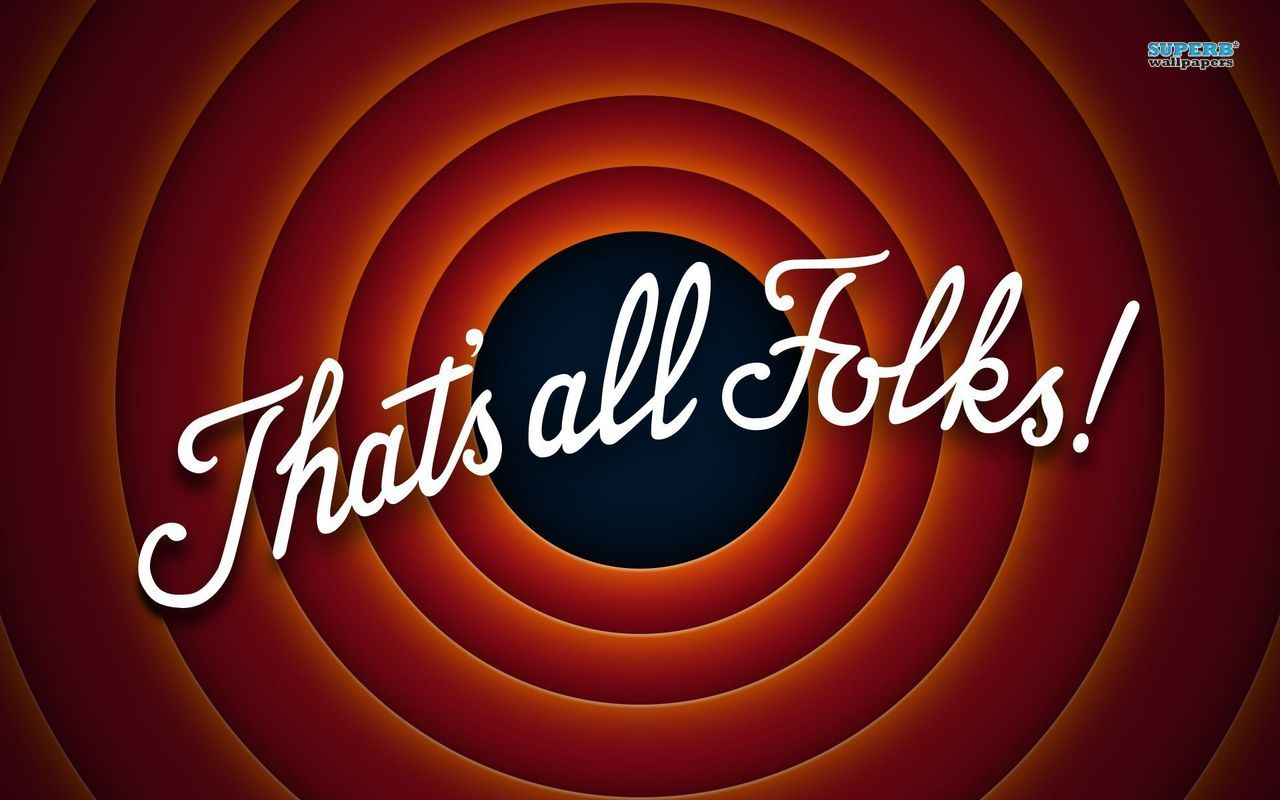